# LLM Fine Tune

In [142]:
import numpy as np
import pandas as pd
import tiktoken
import json
import matplotlib.pyplot as plt

import os

import openai
from openai import OpenAI

In [7]:
medical_reports = pd.read_csv('99-Data/reports.csv')
medical_reports.head()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [12]:
print(medical_reports.report.iloc[0])
print('-' * 100)
print(medical_reports.medical_specialty.iloc[0])

2-D M-MODE: , ,1.  Left atrial enlargement with left atrial diameter of 4.7 cm.,2.  Normal size right and left ventricle.,3.  Normal LV systolic function with left ventricular ejection fraction of 51%.,4.  Normal LV diastolic function.,5.  No pericardial effusion.,6.  Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7.  PA systolic pressure is 36 mmHg.,DOPPLER: , ,1.  Mild mitral and tricuspid regurgitation.,2.  Trace aortic and pulmonary regurgitation.
----------------------------------------------------------------------------------------------------
Cardiovascular / Pulmonary


### Data processing

In [13]:
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [25]:
medical_reports.groupby('medical_specialty').count()

,report
medical_specialty,
Cardiovascular / Pulmonary,371
Gastroenterology,224
Neurology,223
Radiology,273
Surgery,1088


In [15]:
medical_reports.dropna(subset=['report'], inplace=True)

#### Train Valid Test 
- 110 total points --> 100 Train
- Sampple 10 --> 5 val + 5 test

In [30]:
grouped_data = medical_reports.groupby('medical_specialty').sample(n=110, random_state=123)
grouped_data['medical_specialty'].value_counts()

medical_specialty
Cardiovascular / Pulmonary    110
Gastroenterology              110
Neurology                     110
Radiology                     110
Surgery                       110
Name: count, dtype: int64

In [31]:
val_test_data = grouped_data.groupby('medical_specialty').sample(n=10, random_state=123)
val = val_test_data.groupby('medical_specialty').head(5)
test = val_test_data.groupby('medical_specialty').tail(5)

In [32]:
train = grouped_data[~grouped_data.index.isin(val_test_data.index)]

In [34]:
print(f'Train: {len(train)}')
print(f'Val: {len(val)}')
print(f'Test: {len(test)}')

Train: 500
Val: 25
Test: 25


### Data Statistics 

In [37]:
# count number of tokens
def num_tokens_from_string(string):
    encoding = tiktoken.get_encoding('cl100k_base')
    num_tokens = len(encoding.encode(string))
    return num_tokens

Model gpt-3.5-turbo	
- Training $0.0080 / 1K tokens	
- Input usage $0.0030 / 1K tokens	
- Output usage $0.0060 / 1K tokens


In [42]:
report_lenghts = train['report'].apply(num_tokens_from_string)
report_lenghts.describe()

count     500.000000
mean      653.726000
std       425.851799
min         4.000000
25%       341.250000
50%       591.000000
75%       850.000000
max      3701.000000
Name: report, dtype: float64

In [43]:
report_lenghts.sum()

326863

In [52]:
price_per_training_epoch = report_lenghts.sum() * 0.008/1000
print(f'For one epoch it will be: {round(price_per_training_epoch,2)} $')

For one epoch it will be: 2.61 $


### Data Formatting

In [58]:
train['medical_specialty'].unique()

array(['Cardiovascular / Pulmonary', 'Gastroenterology', 'Neurology',
       'Radiology', 'Surgery'], dtype=object)

System prompt
User --> report
Assitant --> medical_specialty

In [61]:
system_prompt = "Given the medical description report, classify it into on of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery"

In [101]:
sample_prompt = {'messages': [{'role':'system', 'content':system_prompt},
                              {'role':'user', 'content': train['report'].iloc[0]},
                              {'role':'assistant', 'content': train['medical_specialty'].iloc[0]}]}

In [102]:
def df_to_format(df):
    formatted_data = []
    
    for index, row in df.iterrows():
        entry = {'messages': [{'role':'system', 'content':system_prompt},
                              {'role':'user', 'content': row['report']},
                              {'role':'assistant', 'content': row['medical_specialty']}]}
        formatted_data.append(entry)
    return formatted_data

In [103]:
data = df_to_format(train)
with open('99-Data/fine_tuning_data.jsonl', 'w') as f:
    for entry in data:
        f.write(json.dumps(entry))
        f.write('\n')

In [104]:
data[0]

{'messages': [{'role': 'system',
   'content': 'Given the medical description report, classify it into on of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery'},
  {'role': 'user',
   'content': 'REASON FOR CONSULTATION: , Mesothelioma.,HISTORY OF PRESENT ILLNESS: , The patient is a 73-year-old pleasant Caucasian male who is known to me from his previous hospitalization.  He has also been seen by me in the clinic in the last few weeks.  He was admitted on January 18, 2008, with recurrent malignant pleural effusion.  On the same day, he underwent VATS and thoracoscopic drainage of the pleural effusion with right pleural nodule biopsy, lysis of adhesions, and directed talc insufflation by Dr. X.  He was found to have 2.5L of bloody pleural effusions, some loculated pleural effusion, adhesions, and carcinomatosis in the parenchyma.  His hospital course here has been significant for dyspnea, requiring ICU stay.  He also had a chest tube, which wa

In [105]:
val_data = df_to_format(val)
with open('99-Data/fine_tuning_data_val.jsonl', 'w') as f:
    for entry in val_data:
        f.write(json.dumps(entry))
        f.write('\n')

### Fine Tuning

In [106]:
client = OpenAI()

In [107]:
file_upload_resposne = client.files.create(file=open('99-Data/fine_tuning_data.jsonl', 'rb'),
                                           purpose='fine-tune')

In [109]:
file_upload_resposne_val = client.files.create(file=open('99-Data/fine_tuning_data_val.jsonl', 'rb'),
                                               purpose='fine-tune')

In [110]:
fine_tuning_response = client.fine_tuning.jobs.create(training_file=file_upload_resposne.id,
                                                      model='gpt-3.5-turbo',
                                                      hyperparameters={'n_epochs':1},
                                                      validation_file=file_upload_resposne_val.id
                                                      )

In [111]:
fine_tuning_response

FineTuningJob(id='ftjob-1lrW1Xcab9ZpXenl0p174Dbq', created_at=1704754102, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-iLUDzGmfN9Ii52Ut7scDVGtz', result_files=[], status='validating_files', trained_tokens=None, training_file='file-k7eGK9og7RuFezCpy0R0QcQW', validation_file='file-r7QkxD8tifXPqpnOekNgOfhU')

In [117]:
client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-1lrW1Xcab9ZpXenl0p174Dbq', created_at=1704754102, error=None, fine_tuned_model='ft:gpt-3.5-turbo-0613:personal::8et4Pu9X', finished_at=1704755500, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-iLUDzGmfN9Ii52Ut7scDVGtz', result_files=['file-Z8DJsjxoHHGINcZK7fenQYop'], status='succeeded', trained_tokens=351063, training_file='file-k7eGK9og7RuFezCpy0R0QcQW', validation_file='file-r7QkxD8tifXPqpnOekNgOfhU')], object='list', has_more=False)

### Evaluation

In [118]:
train_event = client.fine_tuning.jobs.list_events(fine_tuning_job_id='ftjob-1lrW1Xcab9ZpXenl0p174Dbq',
                                                  limit=500
                                                  )

In [124]:
train_event.data[2].data

{'step': 491,
 'train_loss': 1.430511474609375e-06,
 'valid_loss': 1.430511474609375e-06,
 'train_mean_token_accuracy': 1.0,
 'valid_mean_token_accuracy': 0.25}

In [125]:
train_loss = []
val_loss = []

for item in train_event.data:
    train_data = item.data
    if train_data and 'train_loss' in train_data:
        train_loss.insert(0, train_data['train_loss'])
        val_loss.insert(0, train_data['valid_loss'])

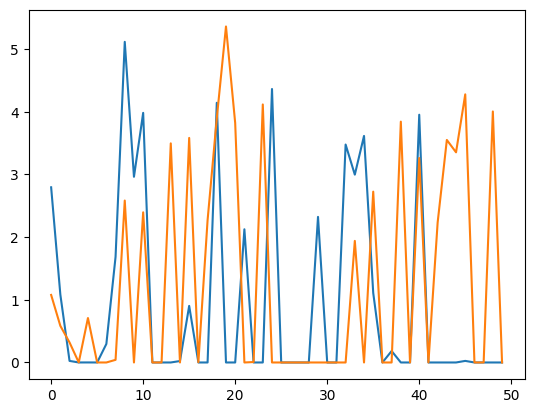

In [129]:
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()


### Apply fine tune model

In [134]:
# general model
completion = client.chat.completions.create(model='gpt-3.5-turbo',
                                           messages = [
                                               {'role': 'system',
                                                'content': system_prompt},
                                               {'role': 'user',
                                                'content': test['report'].iloc[1]}
                                           ])

In [135]:
completion.choices[0].message

ChatCompletionMessage(content='Cardiovascular / Pulmonary', role='assistant', function_call=None, tool_calls=None)

In [138]:
# fine tune model
completion = client.chat.completions.create(model='ft:gpt-3.5-turbo-0613:personal::8et4Pu9X',
                                           messages = [
                                               {'role': 'system',
                                                'content': system_prompt},
                                               {'role': 'user',
                                                'content': test['report'].iloc[1]}
                                           ])

In [139]:
completion.choices[0].message

ChatCompletionMessage(content='Cardiovascular / Pulmonary', role='assistant', function_call=None, tool_calls=None)

In [140]:
def classify_report(report, model):
    completion = client.chat.completions.create(model=model,
                                           messages = [
                                               {'role': 'system',
                                                'content': system_prompt},
                                               {'role': 'user',
                                                'content': report}
                                           ])
    return completion

In [141]:
predicted_classes = []
ground_truth_classess = []

for line in test.iterrows():
    report, speciality = line[1]['report'], line[1]['medical_specialty']
    ground_truth_classess.append(speciality.strip())
    prediction = classify_report(report, model='gpt-3.5-turbo')
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [143]:
# accuracy general model
(np.array(predicted_classes) == np.array(ground_truth_classess)).mean()

0.6

In [144]:
predicted_classes = []
ground_truth_classess = []

for line in test.iterrows():
    report, speciality = line[1]['report'], line[1]['medical_specialty']
    ground_truth_classess.append(speciality.strip())
    prediction = classify_report(report, model='ft:gpt-3.5-turbo-0613:personal::8et4Pu9X')
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [145]:
# accuracy fine tune model
(np.array(predicted_classes) == np.array(ground_truth_classess)).mean()

0.8